In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_slsqp

## Autothermal Reforming

Equilibrium Thermodynamics of the Autothermal Reforming of Methane Reaction

**Equations used are analytically presented in the notebook "Equilibrium Compositions DRM".**

### 1st method with CANTERA

In [2]:
# create empty list to store data
ch4_eq_combined = []
h2o_eq_combined = []
o2_eq_combined = []
co2_eq_combined = []
co_eq_combined = []
h2_eq_combined = []
n2_eq_combined = []
Xch4_eq_combined = []

In [3]:
# for example, create 20 linearly spaced values for temperautre between 473.15-1273.15 Kelvin
Temp_range1 = np.linspace(473.15, 1273.15, 20)

for Temp in Temp_range1:

    gas = ct.Solution('gri30.xml','gri30_mix')
    molar_ratio = {'CH4':0.167, 'H2O':0.416, 'O2':0.017, 'CO2':0.0, 'CO':0.00,
                   'H2':0.0, 'N2': 0.4}
    
    pressure = 101325
    gas.TPX = Temp, pressure, molar_ratio
    
    # transport properties
    feed = gas['CH4', 'H2O', 'O2', 'CO2', 'CO', 'H2', 'N2']
    
    Xi_feed = feed.X # molar fractions
    
    # equilibrate temperature, pressure
    feed.equilibrate('TP')
    
    ch4_eq = feed.X[0]
    ch4_eq_combined.append(ch4_eq)
    
    h2o_eq = feed.X[1]
    h2o_eq_combined.append(h2o_eq)
    
    o2_eq = feed.X[2]
    o2_eq_combined.append(o2_eq)
    
    co2_eq = feed.X[3]
    co2_eq_combined.append(co2_eq) 
    
    co_eq = feed.X[4]
    co_eq_combined.append(co_eq)
    
    h2_eq = feed.X[5]
    h2_eq_combined.append(h2_eq)
    
    n2_eq = feed.X[6]
    n2_eq_combined.append(n2_eq)

### 2nd method with GIBBS MINIMIZATION - (NIST DATA)

In [4]:
def Gibbs_formation_gas(T):
   
    # Heats of formation at 298.15 K in kJ/mol
    Hf298 = [
        -74.85,   # CH4
        -241.826, # H2O
            0.0,  # O2
        -393.51,  # CO2
        -110.53,  # CO
            0.0,  # H2
            0.0,  # N2
               ]
    
    # the values of coefficients slightly change depending on the temperature range
    
    if T < 500 + 273.15:
            # Shomate parameters for each species
            #        A          B           C          D          E            F          G       H
        WB = [
              [-0.703029, 108.4773,    -42.52157,   5.862788,  0.678565, -76.84376, 158.7163,   -74.87310],       # CH4
              [30.09200,  6.832514,     6.793435,  -2.534480,  0.082139, -250.8810, 223.3967,   -241.8264],       # H2O
              [31.32234, -20.23531,     57.86644,  -36.50624, -0.007374, -8.903471, 246.7945,         0.0],       # O2        
              [24.99735,  55.18696,   -33.69137,    7.948387, -0.136638, -403.6075, 228.2431,   -393.5224],       # CO2
              [25.56759,  6.096130,     4.054656,  -2.671301,  0.131021, -118.0089, 227.3665,   -110.5271],       # CO
              [33.066178, -11.363417,  11.432816,  -2.772874, -0.158558, -9.980797, 172.707974,       0.0],       # H2
              [28.98641,   1.853978,   -9.647459,   16.63537,  0.000117, -8.671914, 226.4168,         0.0],       # N2
        ]     

        WB = np.array(WB)
        
    if T > 500 + 273.15:
            # Shomate parameters for each species
            #        A          B           C          D          E            F          G       H
        WB = [
              [-0.703029, 108.4773,    -42.52157,   5.862788,  0.678565, -76.84376, 158.7163,   -74.87310],       # CH4
              [30.09200,  6.832514,     6.793435,  -2.534480,  0.082139, -250.8810, 223.3967,   -241.8264],       # H2O
              [30.03235, 8.772972,      -3.988133,   0.788313, -0.741599, -11.32468, 236.1663,        0.0],       # O2        
              [24.99735,  55.18696,   -33.69137,    7.948387, -0.136638, -403.6075, 228.2431,   -393.5224],       # CO2
              [25.56759,  6.096130,     4.054656,  -2.671301,  0.131021, -118.0089, 227.3665,   -110.5271],       # CO
              [33.066178, -11.363417,  11.432816,  -2.772874, -0.158558, -9.980797, 172.707974,       0.0],       # H2
              [19.50583,   19.88705,   -8.598535,   1.369784,  0.527601, -4.935202, 212.3900,         0.0],       # N2
        ]     

        WB = np.array(WB)

    # Shomate equations
    t = T/1000
    T_H = np.array([t,  t**2 / 2.0, t**3 / 3.0, t**4 / 4.0, -1.0 / t, 1.0, 0.0, -1.0])
    T_S = np.array([np.log(t), t,  t**2 / 2.0,  t**3 / 3.0, -1.0 / (2.0 * t**2), 0.0, 1.0, 0.0])

    H = np.dot(WB, T_H)        # (H - H_298.15) kJ/mol
    S = np.dot(WB, T_S/1000.0) # absolute entropy kJ/mol/K

    Gjo = Hf298 + H - T*S
    
    return Gjo # is the standard free energy in kJ/mol

Gibbs_formation_gas(200.15)

array([-112.76670288, -280.23233368,  -41.59380213, -436.94621298,
       -150.62409997,  -26.67468942,  -38.88135289])

In [5]:
def func(nj, T, P, P0, R):
    
    nj = np.array(nj)
    
    Gj = Gibbs_formation_gas(T) + R*T*np.log(nj / np.sum(nj) * P / P0)
    
    return np.dot(nj, Gj)

In [6]:
                # CH4,  H2O,   O2,   CO2,  CO,   H2,   N2 
a_jk = np.array([
                 [ 1,    0,    0,    1,    1,    0,     0],   # C balance
                 [ 0,    1,    2,    2,    1,    0,     0],   # O balance
                 [ 4,    2,    0,    0,    0,    2,     0],   # H balance
                 [ 0,    0,    0,    0,    0,    0,     2]    # N balance
                                                        ])

                       # CH4,  H2O,   O2,   N2 
a_jk_inlet = np.array([
                      [ 1,     0,     0,     0],   # C balance
                      [ 0,     1,     2,     0],   # O balance
                      [ 4,     2,     0,     0],   # H balance
                      [ 0,     0,     0,     2]    # N balance
                                          ])


# ratio of inlet species in the gas mixture
inlet_species = np.array([0.167, 0.416, 0.017, 0.4])

# incoming feed
A_k = np.dot(a_jk_inlet, inlet_species)
              
def ec1(nj, T, P, P0, R):
    nj = np.array(nj)
    '''conservation of atoms constraint - equality constraint'''
    return np.dot(a_jk, nj) - A_k


def ic1(nj, T, P, P0, R):
    nj = np.array(nj)
    '''inequality constraint all n>=0'''
    return nj

In [7]:
R = 8.314e-3 # kJ/mol/K
P = 1.0 # atm, this is the total pressure in the reactor
P0 = 1.0 # atm, this is the standard state pressure
inlet_ratio = np.array([0.167, 0.416, 0.017, 0.0, 0.0, 0.0, 0.4])

In [8]:
Temp_range = np.linspace(200+273.15, 1000+273.15, 20)

def min_fun(T):
    n0 = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3]
    sol = fmin_slsqp(func, n0, f_eqcons=ec1, f_ieqcons=ic1, args = (T, P, P0, R))
    yj =sol/np.sum(sol)
    return yj

def multiple_temperatures(Temperatures):
    return np.array([min_fun(T) for T in Temperatures]).T

yj = multiple_temperatures(Temp_range)
yj

C:\Users\Ambrosios\AppData\Local\Temp\ipykernel_3348\2609022321.py:5: RuntimeWarning: invalid value encountered in log
  Gj = Gibbs_formation_gas(T) + R*T*np.log(nj / np.sum(nj) * P / P0)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -215.32757215080767
            Iterations: 38
            Function evaluations: 344
            Gradient evaluations: 38
Optimization terminated successfully    (Exit mode 0)
            Current function value: -224.44298303730028
            Iterations: 17
            Function evaluations: 152
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -233.7276255961275
            Iterations: 15
            Function evaluations: 134
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -243.20049873011698
            Iterations: 59
            Function evaluations: 527
            Gradient evaluations: 59
Optimization terminated successfully    (Exit mode 0)
            Current function value: -252.88501078456315
            Iterations: 13
            Func

array([[1.56134402e-01, 1.52843720e-01, 1.47302534e-01, 1.38834538e-01,
        1.27282387e-01, 1.12634359e-01, 9.49413601e-02, 7.50267378e-02,
        5.35073887e-02, 3.25496922e-02, 1.57014051e-02, 5.95198240e-03,
        1.98799959e-03, 6.56846421e-04, 2.24595344e-04, 8.57410287e-05,
        3.34446547e-05, 1.42725204e-05, 8.21788751e-06, 2.09556496e-06],
       [4.27855686e-01, 4.20695123e-01, 4.08661594e-01, 3.90328416e-01,
        3.65531146e-01, 3.34690517e-01, 2.99013398e-01, 2.61853035e-01,
        2.26237364e-01, 1.96566976e-01, 1.76851984e-01, 1.68391099e-01,
        1.67885276e-01, 1.70272095e-01, 1.73356592e-01, 1.76496351e-01,
        1.79263259e-01, 1.81882558e-01, 1.84120365e-01, 1.86120175e-01],
       [4.13445303e-11, 1.30739461e-12, 4.91074566e-12, 5.93376708e-12,
        5.92204725e-15, 1.19205588e-15, 2.33746220e-18, 3.25023199e-11,
        9.40145602e-12, 8.02321438e-12, 2.75231711e-11, 4.17266729e-12,
        1.94717022e-11, 4.38628566e-12, 1.78904375e-11, 3.9519

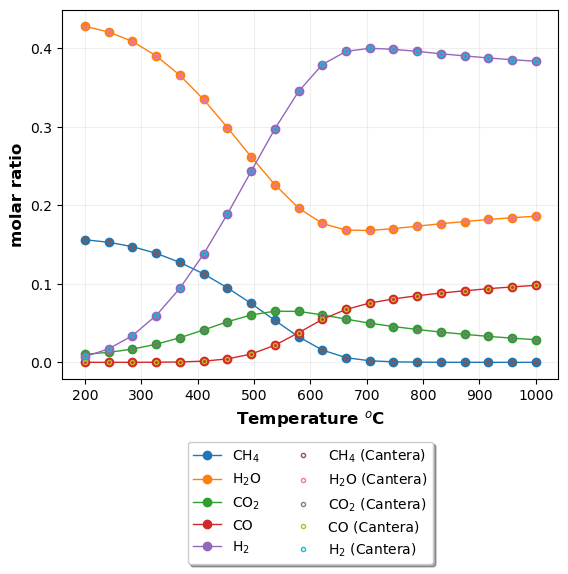

In [9]:
fig, ax = plt.subplots()

species = ['CH$_4$', 'H$_2$O', 'CO$_2$', 'CO', 'H$_2$']

for j, arr in enumerate(np.delete(yj, [2, -1], 0)):
    ax.plot(Temp_range - 273.15, arr, "-o", label = species[j], lw = 1)
    
# define Tc to convert Kelvin to Celcius
Tc = 273.15

ax.plot(Temp_range1-Tc, ch4_eq_combined, '.', mfc = 'None', label = 'CH$_4$ (Cantera)', lw = 1)
ax.plot(Temp_range1-Tc, h2o_eq_combined, '.', mfc = 'None', label = 'H$_2$O (Cantera)', lw = 1)
ax.plot(Temp_range1-Tc, co2_eq_combined, '.', mfc = 'None', label = 'CO$_2$ (Cantera)', lw = 1)
ax.plot(Temp_range1-Tc, co_eq_combined, '.', mfc = 'None', label = 'CO (Cantera)', lw = 1)
ax.plot(Temp_range1-Tc, h2_eq_combined, '.', mfc = 'None', label = 'H$_2$ (Cantera)', lw = 1)
ax.grid(ls="-", alpha = 0.2)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2)

ax.set_ylabel('molar ratio', fontsize=12, fontweight='bold')
ax.set_xlabel('Temperature $^o$C', fontsize=12, fontweight='bold')
ax.grid(ls="-", alpha = 0.2)